# Random Forest Model interpretation

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [111]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [112]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/raw')
df_trn, y_trn = proc_df(df_raw, 'SalePrice')

In [113]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [114]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [115]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,6512
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,5547
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,5518
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,8157
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,7492
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,Low,310G,...,NaN,NaN,NaN,NaN,NaN,2008,12,51,18,7275
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,High,790ELC,...,NaN,NaN,NaN,NaN,NaN,2004,8,35,26,5700
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,High,416D,...,NaN,NaN,NaN,NaN,NaN,2005,11,46,17,6148
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,Low,430HAG,...,NaN,NaN,NaN,NaN,NaN,2009,8,35,27,7527
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,Medium,988B,...,NaN,NaN,NaN,Standard,Conventional,2007,8,32,9,6778


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [116]:
set_rf_samples(50000)

In [117]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2085150129605704, 0.248895993185499, 0.90466810818999954, 0.8893672304667698, 0.89510078985857466]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [118]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.34 s, sys: 12 ms, total: 1.36 s
Wall time: 1.36 s


(9.2669311319303453, 0.31684241613747116)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [119]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 116 ms, sys: 772 ms, total: 888 ms
Wall time: 1.07 s


(9.2669311319303453, 0.31684241613747116)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

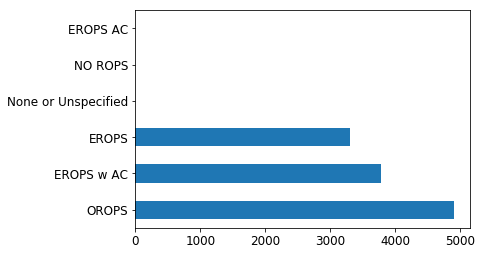

In [120]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [121]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838787,0.272631
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.570114,0.261703
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684749,0.218780


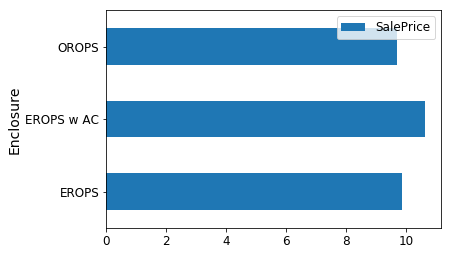

In [122]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh')#, xlim=(0,60000));

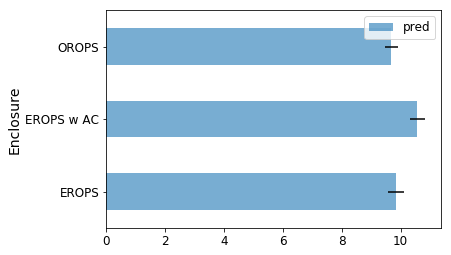

In [123]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6)#, xlim=(0,60000));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

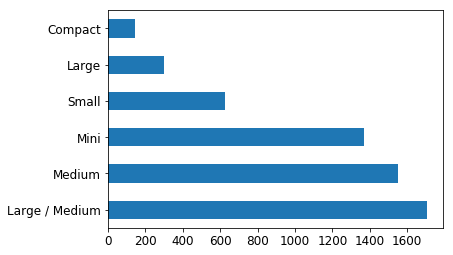

In [15]:
raw_valid.ProductSize.value_counts().plot.barh();

In [16]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.857083,0.319281
Large,10.470589,10.391322,0.369312
Large / Medium,10.691871,10.648810,0.299389
Medium,10.681511,10.627533,0.281921
Mini,9.535147,9.552788,0.242496
Small,10.324448,10.327780,0.304010


In [17]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.035540
Compact           0.032391
Small             0.029436
Large / Medium    0.028115
Medium            0.026527
Mini              0.025385
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [64]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.169756
37,Coupler_System,0.107997
13,ProductSize,0.105777
14,fiProductClassDesc,0.076329
2,ModelID,0.054070
55,saleElapsed,0.051761
10,fiSecondaryDesc,0.047615
19,Enclosure,0.041905
39,Hydraulics_Flow,0.041407
38,Grouser_Tracks,0.037564


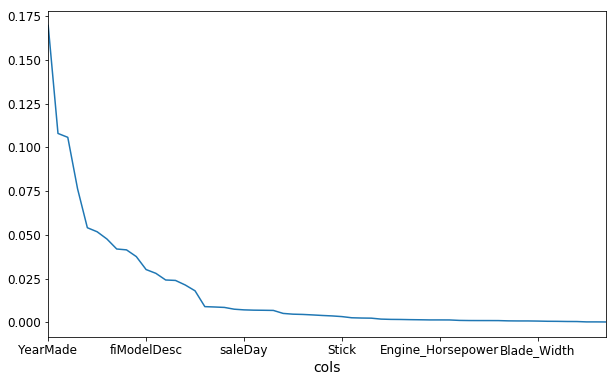

In [65]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [66]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

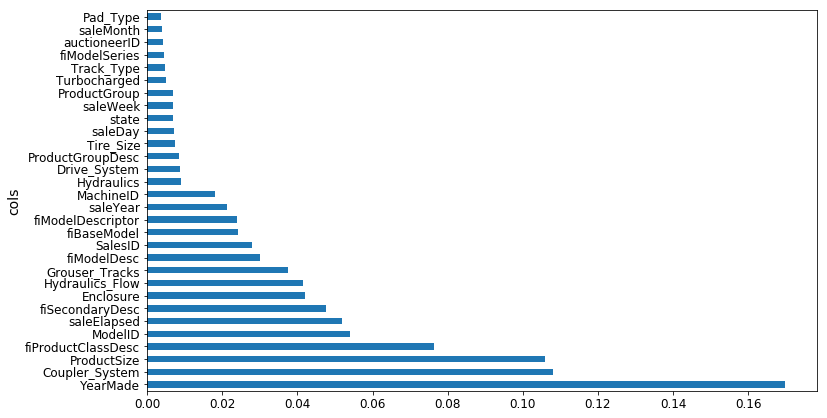

In [67]:
plot_fi(fi[:30]);

In [68]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [69]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [70]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20680392428802552, 0.24432301189552016, 0.9053909442053143, 0.89339520950026963, 0.89445595787536203]


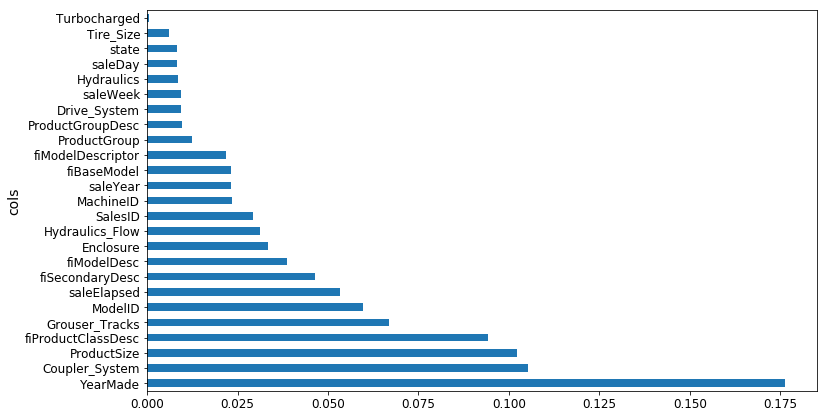

In [71]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [72]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20717899780126803, 0.24656062433981565, 0.91031756168566269, 0.89143360523281101, 0.89421921548438199]


## One-hot encoding

In [27]:
df_trn2, y_trn = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2072123763644958, 0.25239807697031397, 0.91018947616127777, 0.88623201730702361, 0.89286292952156798]


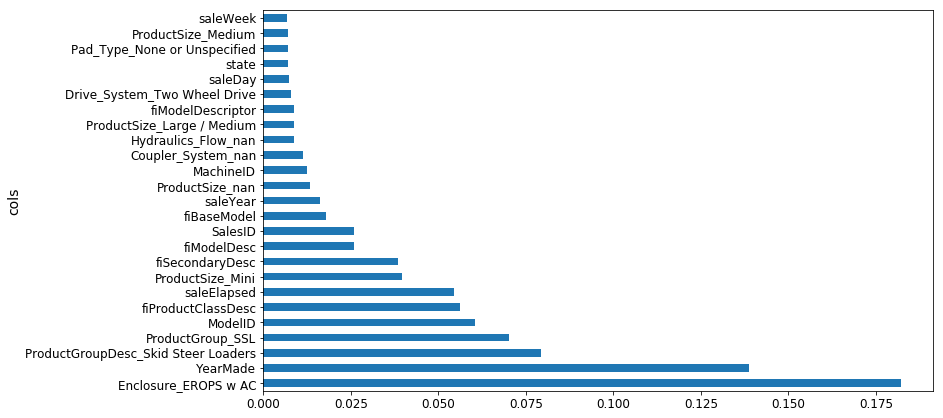

In [28]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [73]:
from scipy.cluster import hierarchy as hc

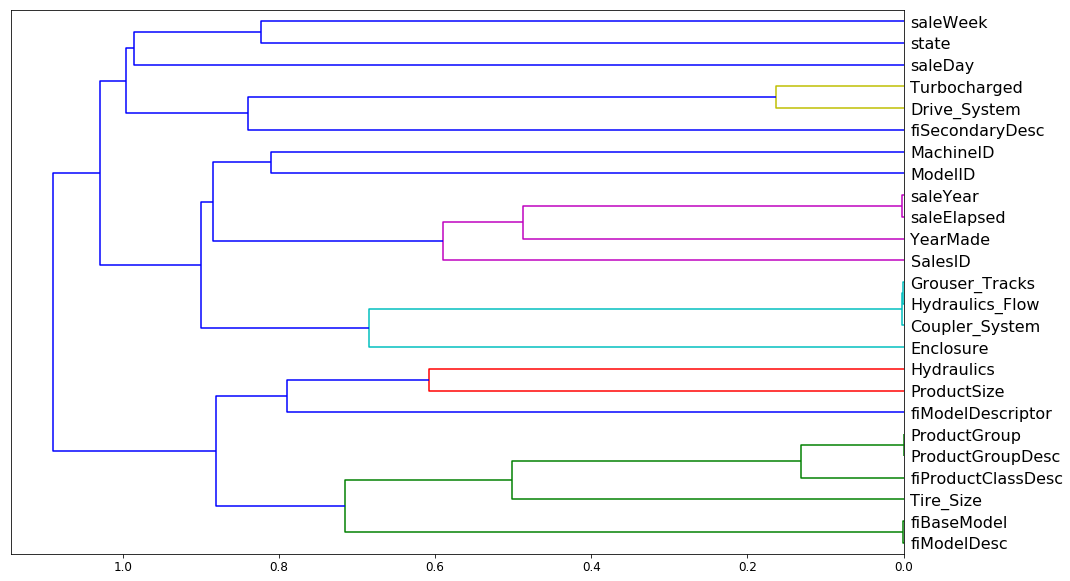

In [74]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [75]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [76]:
get_oob(df_keep)

0.88950015509849467

Now we try removing each variable one at a time.

In [22]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.889391145055
saleElapsed 0.886581595489
fiModelDesc 0.888548081505
fiBaseModel 0.888758946354
Grouser_Tracks 0.889469355031
Coupler_System 0.889205944806


It looks like we can try one from each group for removal. Let's see what that does.

In [77]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.88902603756072929

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [78]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [79]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [80]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [81]:
reset_rf_samples()

In [82]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12750747215780112, 0.22692763467049187, 0.96706994895197762, 0.90803496366852232, 0.90832223739058637]


# Partial dependence

In [83]:
from pdpbox import pdp
from plotnine import *

In [84]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [30]:
df_trn2, y_trn = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

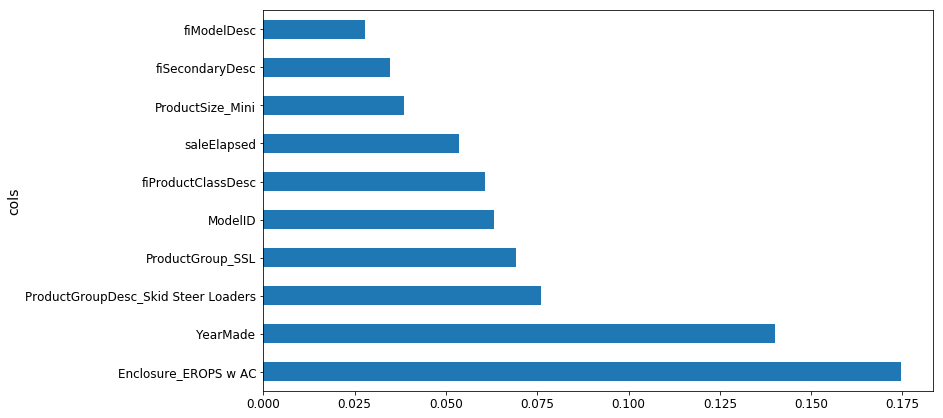

In [31]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

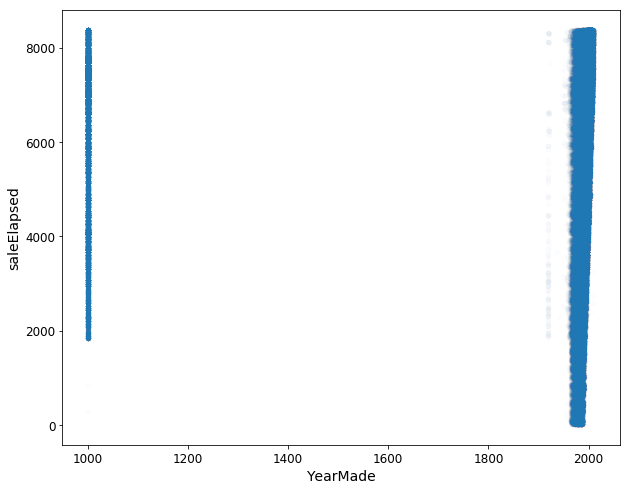

In [44]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [45]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

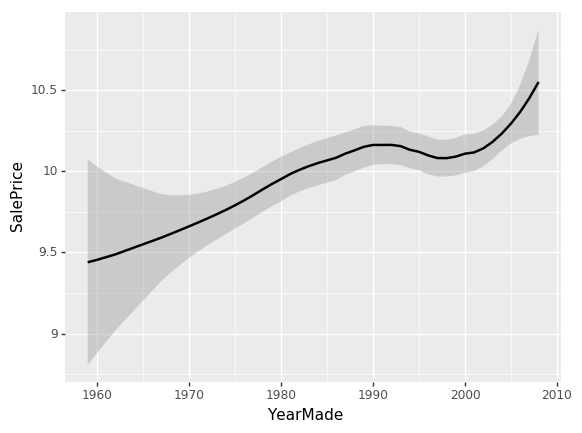

<ggplot: (8729550331912)>

In [46]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [47]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [48]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

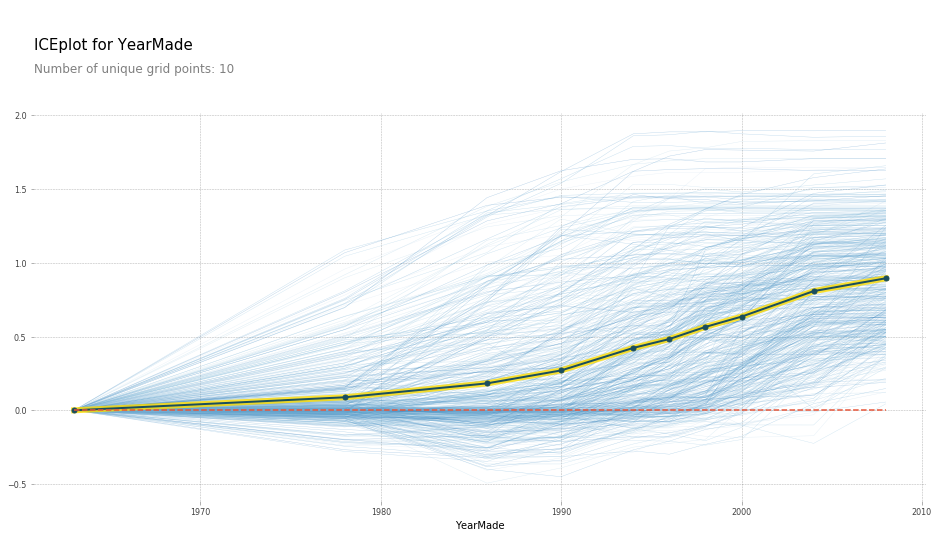

In [49]:
plot_pdp('YearMade')

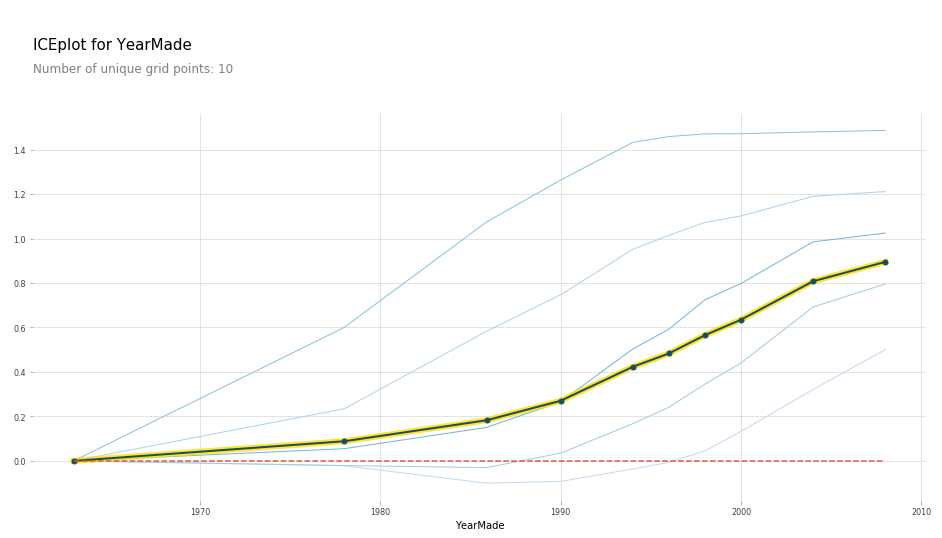

In [50]:
plot_pdp('YearMade', clusters=5)

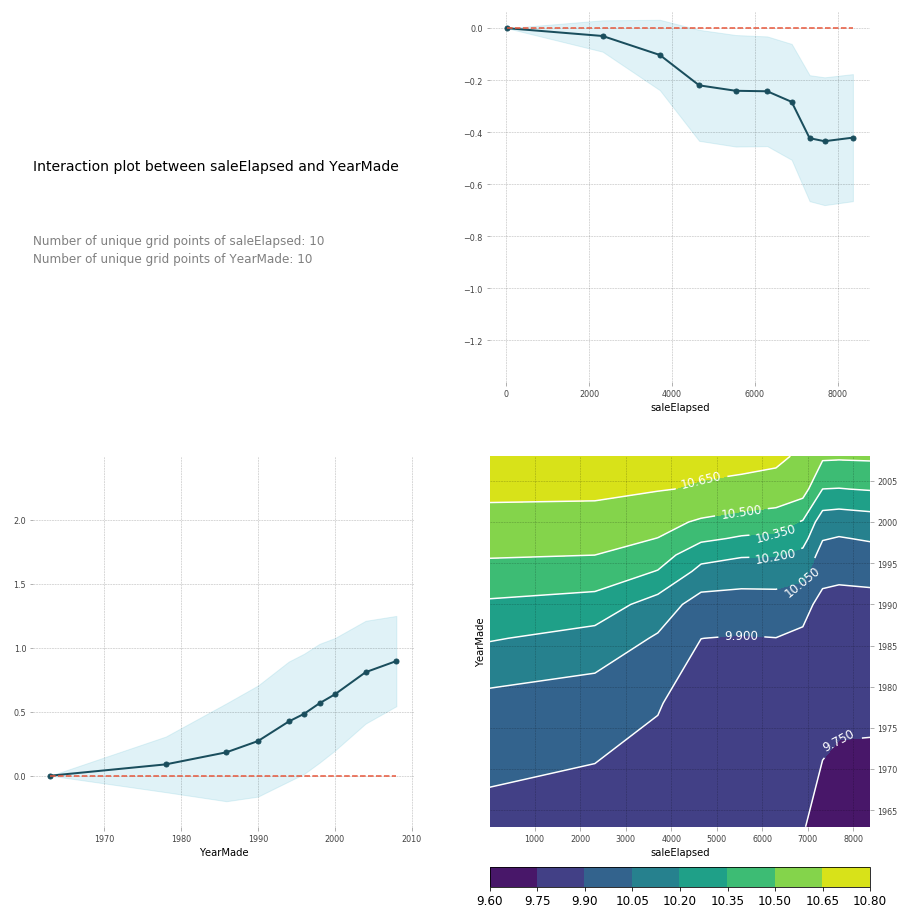

In [51]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

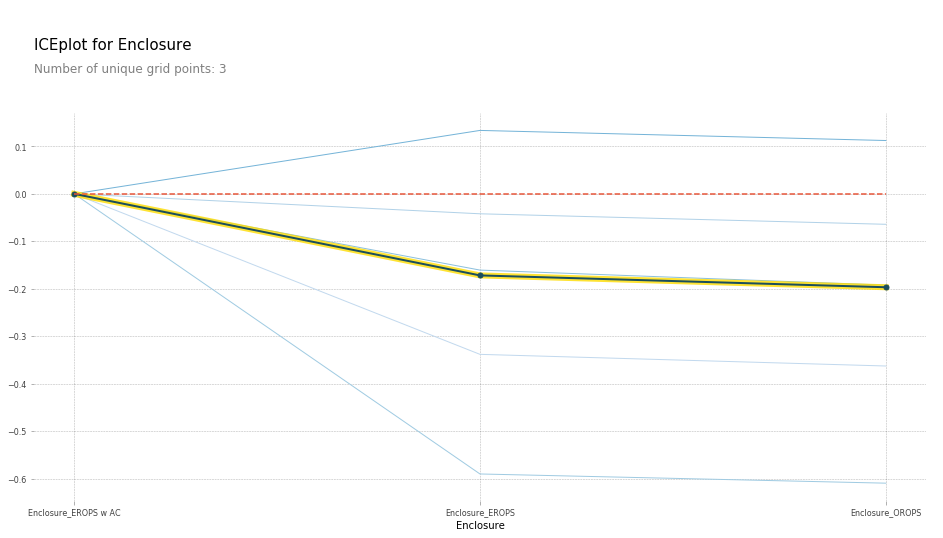

In [52]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [85]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

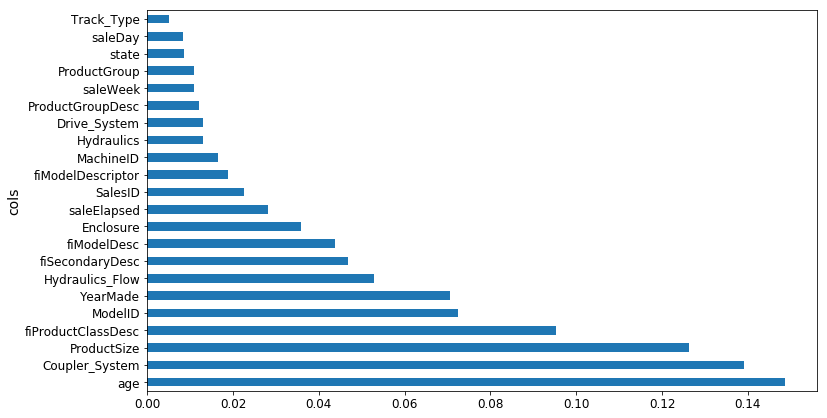

In [35]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [55]:
from treeinterpreter import treeinterpreter as ti

In [56]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [57]:
row = X_valid.values[None,0]; row

array([[   1999,      -1,       4,      16,      -1,     665,    7912,      -1,       0,    3231,
        4364751,      -1, 2300944,      11,      -1,       3,      16,      34,      37,      11]])

In [58]:
prediction, bias, contributions = ti.predict(m, row)

In [59]:
prediction[0], bias[0]

(9.3668993249319534, 10.105252964126896)

In [60]:
[o for o in zip(df_keep.columns, df_valid.iloc[0], sorted(contributions[0]))]

[('YearMade', 1999, -0.53031338456085986),
 ('Coupler_System', nan, -0.1228993248476193),
 ('ProductSize', 'Mini', -0.11538607314124585),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.059591201061703993),
 ('Hydraulics_Flow', nan, -0.040659986723331577),
 ('ModelID', 665, -0.038347329989878484),
 ('saleElapsed', 7912, -0.028415582683501972),
 ('fiSecondaryDesc', nan, -0.027537282430798404),
 ('Enclosure', 'EROPS', -0.013545814595658134),
 ('fiModelDesc', 'KX1212', -0.0090674027858898658),
 ('SalesID', 4364751, 0.0022037191145487965),
 ('fiModelDescriptor', nan, 0.006248731672960561),
 ('MachineID', 2300944, 0.01019005180744248),
 ('Hydraulics', 'Standard', 0.011294453662335257),
 ('Drive_System', nan, 0.014807800391608117),
 ('ProductGroup', 'TEX', 0.02127075166249117),
 ('saleDay', 16, 0.026031859299696959),
 ('state', 'Ohio', 0.028449381484757418),
 ('saleWeek', 37, 0.055648660270215977),
 ('age', 11, 0.071264334259488971)]

In [61]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

In [87]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y = proc_df(df_ext, 'is_valid')

In [88]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998504206918049

In [89]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.803013
5,saleElapsed,0.130507
12,MachineID,0.051895
4,ModelID,0.003156
19,saleWeek,0.003072
0,YearMade,0.002264
9,fiModelDesc,0.001176
1,Coupler_System,0.001085
7,Enclosure,0.000998
22,age,0.000795


In [90]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [94]:
(df_keep[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,401125.000000,401125.000000,401125.000000
mean,1919.712522,5.676324,1217.902518
std,909.021493,2.102982,440.991954
min,1139.246000,0.000000,0.000000
25%,1418.371000,4.281000,1088.697000
50%,1639.422000,6.274000,1279.490000
75%,2242.707000,7.371000,1468.067000
max,6333.342000,8.382000,2486.330000


In [96]:
(df_keep[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,401125.000000,401125.000000,401125.000000
mean,1919.712522,5.676324,1217.902518
std,909.021493,2.102982,440.991954
min,1139.246000,0.000000,0.000000
25%,1418.371000,4.281000,1088.697000
50%,1639.422000,6.274000,1279.490000
75%,2242.707000,7.371000,1468.067000
max,6333.342000,8.382000,2486.330000


In [91]:
x.drop(feats, axis=1, inplace=True)

In [92]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9786001869741352

In [93]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.235245
0,YearMade,0.191591
16,saleWeek,0.130611
4,ModelID,0.083271
14,saleDay,0.069868
8,fiModelDesc,0.064401
15,state,0.054490
3,fiProductClassDesc,0.034405
5,fiSecondaryDesc,0.024272
6,Enclosure,0.023637


In [97]:
set_rf_samples(50000)

In [100]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade']

In [101]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20773928837987723, 0.24668083202051636, 0.90939728307144485, 0.89132771893516716, 0.89338349702789732]


In [102]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.2114647573335109, 0.24534181440850786, 0.90615128112585241, 0.89250429322987024, 0.89272524911015061]
saleElapsed
[0.21378081539574878, 0.2542965163652306, 0.89934871421433049, 0.88451414459287214, 0.88753356276330686]
MachineID
[0.20658565345587532, 0.24658348299599545, 0.91034800104312164, 0.89141347390052084, 0.89512568866953512]
age
[0.21382988089887853, 0.24683912936911798, 0.90849430028161848, 0.89118820218933903, 0.89217934715932712]
YearMade
[0.2085327729078806, 0.25040738951499253, 0.90911683091034856, 0.88801953786123933, 0.8925053302183088]


In [103]:
reset_rf_samples()

In [104]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'age'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13511391641882614, 0.21851901572010646, 0.96253708493190959, 0.914724073759277, 0.91083086660215828]


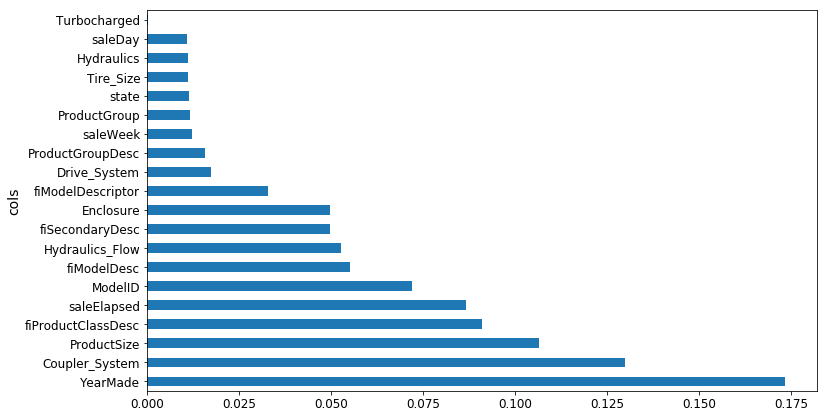

In [105]:
plot_fi(rf_feat_importance(m, X_train));

In [106]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [107]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 5s, sys: 2.07 s, total: 6min 7s
Wall time: 16.4 s
[0.07949028325047232, 0.21245303531335308, 0.98649100690152536, 0.91934353898455934, 0.91675610200556112]
